# "1-800-Headline-Bling" Process Book

**Team Name**  
carrots-and-pretzels  

**Team Members**  
David Boone, Joshua Grossman, Benjy Levin, Ana Marinovic, Jackson Okhun  

**Project TF**  
Brian Feeny  

**Github Repository**  
https://github.com/amarinovic/carrots-and-pretzels

###Overview and Motivation

Are newspaper headlines reliable indicators of the content of their articles? Is there sufficient information in a headline to predict the sentiment of an article? Does the sentiment of the headline itself reflect the sentiment of its article? We started our project with one goal in mind: predict the sentiment of newspaper articles using their headlines and article metadata (e.g. date or section). This notebook will walk through our thought process over the last few weeks.

Our project attempts to understand and quantify relationships that may or may not exist between attributes of a given news article and the overall sentiment of the body of the news article itself. We use "sentiment" to refer to the emotional subjectivity of a news article; in particular, we look at positive or negative attitudes that deliberate language use may convey. We hypothesize that the attributes of a news article - e.g., sentiment of headline, sentiment of first paragraph, day of the week published - hold significant predictive power as to the sentiment of the text of the news article, and so our project intends to construct a model from an appropriately weighted combination of these attributes.

###Initial Questions

We planned our approach with the following exploratory questions in mind:
* How has newspaper sentiment changed over time?
* What does sentiment look like over the past few decades?
 * Is there seasonality in sentiment each year?
 * Do certain months correlate with certain sentiment?
 * Do certain weekdays correlate with certain sentiment?
 * Do certain times of the day correlate with certain sentiment?
* Do certain sections exhibit different sentiment?
* Do top stories typically express different sentiment?
* Does sentiment change within an article?
* Does sentiment intensity change with big events (e.g. 9/11)?

These questions guided our exploration of the data, though not all of them were answered.

Early in the course of our project, Brian Feeny, our project TF, suggested using the Python Natural Lanuage Toolkit (NLTK) library to carry out our sentiment analysis. We simultaneously researched NLTK capabilities while wrangling our data, though the NLTK research and initial implementation will be explained in more detail in the "Cleaning and Exploring the Data" section.

#Wrangling the Data

First off, we needed data. The New York Times API looked to be a great source of information. Furthermore, if parsing the New York Times turned out to be easy, we could perhaps incorporate some additional newspapers into our project without much trouble. We could perhaps even explore sentiment across different newspapers. A few hours of research into the New York Times API presented a few problems:

1. The API does not provide the article body, only other metadata (e.g. headline).
2. The API limits requests to 10,000 articles per day.

The first issue completely destroyed the possibility of using the API to gather our data. Perhaps scraping the New York Times directly could provide some answers? A few more hours of research into scraping the New York Times gave us a clear and unfortunate answer: scraping articles directly with a subscription to the New York Times was completely illegal. Given that the CS109 budget does not account for criminal fines incurred by students, we gave up on the New York Times.

So where to go from there? We needed a reliable newspaper data source that was free to access, whether with an API or by scraping articles directly. A connection in Harvard Crimson tech graciously provided us with a solution: a mySQL dump of every Crimson article ever published (and digitally stored). What seemed to be a miraculous source turned out to be a dud. The Crimson data was stored in about 100 massive tables with little to no documentation of the keys that linked them. We spent an entire evening trying to link up the tables; even though our SQL skills improved, our best attempt to turn 1.7 million rows of article bodies into something useful with JOIN statements gave us a table with, drum roll, 523 rows. There was no way to gather the data reliably from the Crimson dump.

###... now what?

We quickly turned to the scraping skills taught in HW1. Using <a href=http://www.thecrimson.com/sitemap/>this page</a> as our base, we gathered every article published between the start of 2011 and the present into a JSON file using the scraping code below.

Note: when we realized that the Crimson mySQL database was going to have serious issues, we wrote up some code to scrape CNN for articles. Though we did not end up using this code, it is below.

Second Note: Below the CNN interlude, there is some code that we used to test whether we could scrape a single article from the Crimson and sentiment score it.

Our main scraping code is below. It is commented out, as it takes many hours to run.

In [1]:
# years = range(2011,2016)

# # A function for cleaning the html of a page corresponding to a single article.
# # This function takes the article url stem as input and outputs a dictionary of article information. 
# # The dictionary has the following keys: "body", "date", "day", "headline", "month", "section", "tags", "url", "year"
# def get_article_info(article_url):
    
#     article = {}  

#     # url
#     article_url = "http://www.thecrimson.com" + str(article_url)
#     article["url"] = article_url
        
#     # page html     
#     article_page = requests.get(article_url)
#     page_html = BeautifulSoup(article_page.text, "html.parser")
        
#     # Section   
#     # Arts, Flyby, Multimedia, Magazine, News, Opinion, Sports
#     nav_bar = page_html.find_all("li", attrs={"class": "nav-published"})
#     for tab in nav_bar:
#         if tab.find("a", attrs={"class": "active"}) is not None:
#             article["section"] = tab.find("a", attrs={"class": "active"}).getText()
                
#     # Headline
#     # Articles classified as "flyby" have a slightly different page layout.
#     try:
#         if article["section"] is not "flyby":
#             article["headline"] = page_html.find("div", attrs={"id": "article-header"}).contents[1].getText()        
#     except:
#         article["section"] = "Flyby"
#         article["headline"] = re.sub('\n ', '', re.sub(' +', ' ', page_html.find("h1", attrs={"class": "article-heading"}).contents[1].getText())) 
        
#     # Date
#     article["date"] = page_html.find("time").get("datetime")
#     date_split = article["date"].split("-")
#     article["year"] = date_split[0]
#     article["month"] = date_split[1]
#     article["day"] = date_split[2]
        
#     # Tags
#     tags_list = []
#     tag_div = page_html.find("div", attrs={"id": "article-tags"})
#     try:
#         tags = tag_div.find_all("a")
#         for tag in tags:
#             tags_list.append(re.sub('\xa0', ' ', tag.getText()))
#     # Some articles contain no tags.
#     except:
#         tags_list = []
#     article["tags"] = tags_list            
        
#     # Article body        
#     article_body = re.sub(" +", ' ', re.sub("\n", '', re.sub("<br/><br/>", ' ', page_html.find("div", attrs={"id": "text"}).getText().split("Want to keep up with breaking")[0])))
#     if article_body is None:
#         article_body = page_html.find("div", attrs={"class": "article-body"}) 
#     article["body"] = article_body
        
#     return article


In [2]:
# # Dictionary for storing the articles, keyed by year, date, article url stem.
# articles = {}

# for year in years:
    
#     year_url = "http://www.thecrimson.com/sitemap/" + str(year) +"/"   
    
#     articles_by_date = {}
    
#     year_page = requests.get(year_url)
#     date_cells = BeautifulSoup(year_page.text, "html.parser").find_all("li", attrs={"class": "sitemap-cell"})
    
#     for date in date_cells:
        
#         date_url = "http://www.thecrimson.com" + date.find("a").get("href").encode("utf-8")

#         date_page = requests.get(date_url)
#         page_cells =  BeautifulSoup(date_page.text, "html.parser").find_all("li", attrs={"class": "sitemap-cell"})
        
#         article_pages = {}
#         for page in page_cells:
            
#             page_url = page.find("a").get("href").encode("utf-8")
            
#             try:
#                 article_pages[page_url] = get_article_info(page_url)
#             except: 
#                 continue
            
#         articles_by_date[date.getText().encode("utf-8")] = article_pages
        
#         time.sleep(random.uniform(0.1, 1.0)) 
    
#     articles[str(year)] = articles_by_date

In [3]:
# # Write the article dictionary to a file
# fd = open("articles_2011_2015.json","w+")
# json.dump(articles, fd)
# fd.close()

Our dataset of articles from 2011-2015 contains roughly 18,000 articles. We stored all the data in a single json file - articles_2011_2015.json. Below is an example of a single article dictionary contained in our articles dataset, again commented out: 

In [4]:
# articles['2015']['4/21']['/column/artistic-matchmaker/article/2015/4/21/artist-matchmaker-art-as-a-different-reality/']

###CNN Scraping Interlude...

In [5]:
# this could potentially be used to do our analysis on CNN instead of the crimson
# below are the basic functionalities of the API wrapper
# allows us to download a corpus of recent articles (over 1000 on my first go)
# then we can reference all the relevant attributes of the articles that we may need
# pip install newspaper
# import newspaper
# cnn_paper = newspaper.build('http://cnn.com')
# for article in cnn_paper.articles:
#     print(article.url)
# for category in cnn_paper.category_urls():
#     print(category)
# article = cnn_paper.articles[0]
# article.download()
# article.parse()
# other available attributes
# article.html
# article.authors
# article.top_image
# article.movies
# print article.title
# article.nlp()
# print article.keywords
# print article.summary
# cnn_paper.size()
# len(cnn_paper.articles)

###...End of CNN Scraping Interlude

###Test Scrape of Single Article Interlude...

In [6]:
# #this was our first attempt at just scraping a single article
# from bs4 import BeautifulSoup
# import urllib
# yeardict = {}
# r = urllib.urlopen('http://www.thecrimson.com/sitemap/2015/').read()
# soup = BeautifulSoup(r)
# sitemap = soup.find("ul",attrs={"class" : "sitemap-issue"}).find_all("a")
# count = 0
# for day in sitemap:
# 	if count == 2:
# 		oneday = day.get("href")
# 	count +=1
# 	print day.get("href")

# r2 = urllib.urlopen('http://www.thecrimson.com'+ oneday).read()

# soup2 = BeautifulSoup(r2)
# sitemap2 = soup2.find("ul",attrs={"class" : "sitemap-article"}).find_all("a")
# print len(sitemap2)
# for article in sitemap2:
# 	articlename = article.get("href")
# 	r3 = urllib.urlopen('http://www.thecrimson.com/' + articlename).read()
# 	soup3 = BeautifulSoup(r3)
# 	print articlename
# 	print soup3.find_all('meta')
# 	#print soup3.find(id='article-body')
# 	#print soup3.find_all("div", attrs={"id": "article-body"})
# 	body=[]
# 	# if (soup3.find_all(id = 'article-body')==[]):
# 	# 	body =  soup3.find_all(class_ = 'article-body')#.().encode("utf-8")
	
# 	# if body == []:
# 	# 	body = soup3.find_all(id = 'article-body')#.get_text().encode("utf-8")
# 	body = soup3.find_all(id = 'text')#.get_text().encode("utf-8")
# 	print body
# 	#print soup3.find(attrs={'id':'article-tags'})
# 	#yeardict[article.get("href")]

In [7]:
# from textblob import TextBlob
# text = article["article_body"]
# blob = TextBlob(text)
# sentiment_sum = 0.0
# #print article["article_body"].sentiment.polarity
# for sentence in blob.sentences:
#     #print str(sentence)
#     sentiment_sum+=sentence.sentiment.polarity
    
# print sentiment_sum
# print sentiment_sum/len(blob.sentences)
# print blob.sentiment

# headline = TextBlob("Losing")
# print headline.sentiment

In [8]:
# from vaderSentiment.vaderSentiment import sentiment as vaderSentiment
# text = article["article_body"]
# blob = TextBlob(text)

# for sentence in blob.sentences:
#         print sentence,
#         vs = vaderSentiment(sentence)
#         print "\n\t" + str(vs)

###... End of Test Scrape of Single Article Interlude

With our data wrangled, we looked to get all of our information into a Pandas dataframe. See below for the code that we used.

In [2]:
import json
from nltk.tag import pos_tag
import nltk.data
from nltk.corpus import stopwords
import unicodedata
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sys
# for some reason the library redirects to terminal standard out - so reset this to view output below
nb_stdout = sys.stdout
from vaderSentiment.vaderSentiment import sentiment as vaderSentiment
sys.stdout = nb_stdout
import json
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
import pickle
import seaborn as sns
import datetime
sns.set_style("whitegrid")
sns.set_context("poster")
import statsmodels.api as sm
from statsmodels.formula.api import glm, ols
from statsmodels.api import add_constant
from sklearn.metrics import mean_squared_error
from sklearn.cross_validation import train_test_split 
import re
from bs4 import BeautifulSoup
import json
import random
import requests
import time


Here we open the JSON file with the articles.

In [10]:
fd = open('articles_2011_2015.json')
data = json.load(fd)

Here we turn the JSON contents into a list of dictionaries for conversion to Pandas.

In [11]:
articles = []
for year in data.keys():
    for date in data[year].keys():
        for url_title in data[year][date].keys():
            articles.append(data[year][date][url_title])

Here we turn the dictionaries into a Pandas dataframe. Included in the dataframe is a unique index for each article, the body of each article, the publishing date, the month and day as strings, the headline, the article tags, the article URL, and the year as a string.

In [12]:
articledf = pd.DataFrame(articles)
articledf.head(5)

,body,date,day,headline,month,section,tags,url,year
0,Olivia R. Miller '16 and Tess V. Davison '16 ...,2015-09-13,13,"Women Audition for Pudding Cast, But It Will S...",09,News,"[College, On Campus, Student Groups, College L...",http://www.thecrimson.com/article/2015/9/13/wo...,2015
1,"UPDATED: September 12, 2015, at 5:00 p.m. Luke...",2015-09-13,13,Lowell Sophomore Dies ‘Suddenly and Unexpectedly’,09,News,"[College, Breaking News, Lowell, College News]",http://www.thecrimson.com/article/2015/9/13/lo...,2015
2,Longtime Harvard Management Company investor A...,2015-09-13,13,Wiltshire Will Leave Harvard Management Company,09,News,"[Central Administration, Endowment, University...",http://www.thecrimson.com/article/2015/9/13/wi...,2015
3,"UPDATED: September 15, 2015, at 4:51 a.m.Speak...",2015-09-13,13,Luke Tang ’18 Lived a Life of Faith and Empathy,09,News,"[College, Student Life, College Life, Obituary...",http://www.thecrimson.com/article/2015/9/13/lu...,2015
4,Yes QueenTerrorism is defined by Merriam-Webst...,2015-09-12,12,Protecting Providers,09,Opinion,[Columns],http://www.thecrimson.com/column/yes-queen/art...,2015


#Cleaning and Exploring the Data

At this point, we needed to clean the data by (1) typing the columns correctly (e.g. day of the month as an int instead of a string), (2) adding additional columns of data (e.g. day of the week as a 0-6 int using datetime to determine the day of the week of each date), and (3) calculate a sentiment score of each article body with NLTK. 

Some background: it's difficult to accurately calculate the sentiment of a large body of text. In general, the NLTK library analyzes a phrase by comparing each word in the phrase to known dictionaries of positive and negative words and then summing up the positive and negative sentiment contribution of each word in the phrase. This summation leads to a sentiment score. NLTK can also infer the part of speech of a word (e.g. proper noun or adjective) and order of words in a phrase and incorporate this information into the sentiment score. Because large bodies of text are filled with "noisy" sentiment and a lot of neutral words, NLTK works best when analyzing Tweet-sized chunks of text. Thus, before calculating the sentiment score of each article, we needed to find a method to accurately calculate the sentiment score of a large article.

We explored the functionality of NLTK using <a href=http://text-processing.com/demo/sentiment/>this tool</a>. We quickly realized the limits of this tool by pasting in long, polarizing articles and getting either neutral sentiment scores or completely wrong sentiment scores (e.g. a positive score on a clearly negative article)

We then found <a href=http://www.icwsm.org/papers/3--Godbole-Srinivasaiah-Skiena.pdf>this paper</a>. In summary, the paper suggests that the best way to calculate the sentiment score of a large article is by splitting the text into chunks separated by proper nouns, analyzing each chunk separately, and then averaging the scores to calculate an overall sentiment score of the article. Thus, we wrote a few different functions to parse an article for proper nouns. 

In [13]:
from nltk import pos_tag, ne_chunk, tree
from nltk.tokenize import SpaceTokenizer
sentence ="was an American student at the University of Wyoming who was beaten, tortured and left to die near Laramie, Wyoming on the night of October 6, 1998, and died six days later at Poudre Valley Hospital in Fort Collins, Colorado, on October 12, from severe head injuries."
def get_proper_nouns(sentence):
    tokenizer = SpaceTokenizer()
    toks = tokenizer.tokenize(sentence)
    pos = pos_tag(toks)
    chunked_nes = ne_chunk(pos)
    nes = [' '.join(map(lambda x : x[0], ne.leaves())) for ne in chunked_nes if isinstance(ne, tree.Tree)]
    return nes
print get_proper_nouns(sentence)

[u'American', u'University', u'Poudre Valley Hospital', u'Fort']


In [14]:
#breaks the sentence into (word, part of speech) tuples
tagged_sent = pos_tag(sentence.split())
#NNP is proper noun tag
propernouns = [word for word,pos in tagged_sent if pos == 'NNP']
print propernouns

['University', 'Wyoming', 'Laramie,', 'Wyoming', 'October', 'Poudre', 'Valley', 'Hospital', 'Fort', 'Collins,', 'Colorado,', 'October']


As you can see, each method has its upsides and downsides. The first method can pull compound proper nouns (e.g. Poudre Valley Hospital), but it misses some proper nouns in the sentence. The second method takes a bit long to run and cannot process compound proper nouns, but it does gather most of the proper nouns in the sentence. Since the first method is inaccurate and the second method takes very long to run for full articles, we decided to scrap the proper noun separated method.

Taking a page from the Twitter sentiment model (<a href=http://www.laurentluce.com/posts/twitter-sentiment-analysis-using-python-and-nltk/>see here</a>), we decided to still analyze the article based on chunks. To keep things simple, we used each sentence as a chunk.

Please note that we are using the VADER NLTK library to calculate sentiment scores. You can find the source code <a href=http://www.nltk.org/_modules/nltk/sentiment/vader.html>here</a>. VADER is designed for analyzing text related to social media. VADER also uniquely calculates a compound sentiment score. This score takes into account  positive, negative, and neutral sentiment scores (each on a 0 to 1 scale) and normalizes them to a single -1 to 1 score where scores closer to -1 are more negative and scores closer to 1 are more positive (and closer to 0 are more neutral). We will primarily use this compound score in our analyses.

In [15]:
# gathers article body with dataframe row index in a tuple --> list of (index, body) for all articles
def make_tuples(articledf):
    article_tuples = []
    for index, row in articledf.iterrows():
        article_tuples.append((index, row['body'], row['headline']))
    return article_tuples

# removes unicode from article
def clean_article(article):
    sentences = unicodedata.normalize('NFKD', article).encode('ascii','ignore')
    sentences = tokenizer.tokenize(sentences)
    #remove all strings less than 3 characters if desired
    #sentences = [re.sub(r'\b\w{1,2}\b', '', sentence) for sentence in sentences]
    return sentences

# performs vader sentiment analysis on each sentence in the article: "may the force be with you."
def vaderify(index, article, headline):
    score_dict = {'neg':[],'neu':[],'pos':[],'compound':[]}
    headline_dict = {'neg':[],'neu':[],'pos':[],'compound':[]}
    #sentiment of first sentence
    if len(article) > 0:
        #calculate sentiment of first sentence
        first_sentiment = vaderSentiment(article[0])['compound']
    else:
        first_sentiment = None
    for part in headline:
        vs = vaderSentiment(part)
        #add headline sentiment to headline sentiment dictionary
        for k,v in vs.iteritems():
            headline_dict[k].append(v)
    for sentence in article:
        vs = vaderSentiment(sentence)
        #add sentence sentiment to article sentiment dictionary
        for k,v in vs.iteritems():
            score_dict[k].append(v)
    #polarized ("pol") scores eliminate sentences with weak positive or negative scores
    #bounded compound scores eliminate sentences with weak to moderate compound scores
    return (index, {'first_sentiment': first_sentiment, 'headline_sentiment': np.mean(headline_dict['compound']), \
                    'neg': np.mean(score_dict['neg']),'neu': np.mean(score_dict['neu']),\
                    'pos': np.mean(score_dict['pos']),'compound': np.mean(score_dict['compound']), \
                    'pol_neg': np.mean([score for score in score_dict['neg'] if score > 0.1]), \
                    'pol_pos': np.mean([score for score in score_dict['pos'] if score > 0.1]), \
                     'bounded_compound': np.mean([score for score in score_dict['compound'] if np.abs(score) >= 0.5])})
                

# returns a list of dictionaries with the sentiment scores of each article in each dictionary
def build_score_dicts(articles, vader_function, suppress_reports):
    score_dicts = []
    for index, article, headline in articles:
        score_dict = vader_function(index, clean_article(article), clean_article(headline))
        score_dicts.append(score_dict) 
        #prints score report
        if (suppress_reports == False):    
            print 
            print 'article ' + str(index)
            print "############"
            print_results(score_dict)
            print_polarized_results(score_dict)
    return score_dicts

#used if histograms of each article's sentiments are needed, also prints score report for each article
def build_scoredfs(score_dicts):
    scoredfs = []
    for index, score_dict in score_dicts:
        scoredf = pd.DataFrame(score_dict)
        scoredfs.append(scoredf)
    return scoredfs

#used to make histograms of the sentiment of the sentences in each article if desired
def make_hists(scoredfs):
    # initializes subplot index
    subplot_num = 1
    # sets up a clean group of 24 subplots
    num_plots = len(articles)
    plt.subplots(nrows=int(np.sqrt(num_plots)), ncols=int(np.sqrt(num_plots)), figsize=(16, 24), tight_layout=True)
    for scoredf in scoredfs:
        plt.subplot(int(np.sqrt(num_plots))+1,int(np.sqrt(num_plots))+1,subplot_num)
        plt.title('article' + str(subplot_num))
        #compound score is the normalized sum of sentiments, between -1 and 1
        plt.xlabel('Compound Score')
        plt.ylabel('Count')
        plt.hist(scoredf['compound'])
        subplot_num += 1

#puts everything together
def do_all(articledf, vader_function, suppress_hists = True, suppress_reports = True):
    if suppress_hists == True:
        return build_score_dicts(make_tuples(articledf), vader_function, suppress_reports)
    else:
        return make_hists(build_scoredfs(build_score_dicts(make_tuples(articledf), vader_function, suppress_reports)))
        

        
def print_polarized_results(score_dict):
    print "POLARIZED SCORE REPORT"
    print "############"
    print "Avg Pos: " + str(np.mean([score for score in score_dict['pos'] if score > 0.1]))
    print "Avg Neg: " + str(np.mean([score for score in score_dict['neg'] if score > 0.1]))
    print "Avg Neutral: " + str(np.mean(score_dict['neu']))
    print "Avg Compound: " + str(np.mean(score_dict['compound']))
    print "############"
    
def print_results(score_dict):
    print "STANDARD SCORE REPORT"
    print "############"
    print "Avg Pos: " + str(np.mean([score for score in score_dict['pos']]))
    print "Avg Neg: " + str(np.mean([score for score in score_dict['neg']]))
    print "Avg Neutral: " + str(np.mean(score_dict['neu']))
    print "Avg Compound: " + str(np.mean(score_dict['compound']))
    print "############"

In [16]:
%%time
score_dicts = do_all(articledf, vaderify)

CPU times: user 10min 2s, sys: 14 s, total: 10min 16s
Wall time: 10min 6s


In [17]:
# this can be used to save the above score_dict to file
# in the event of a kernel crash as it takes ~8 mins to run

# with open('score_dict', 'w+') as f:
#     pickle.dump(score_dicts, f)

# with open('score_dict', 'r') as f:
#     score_dicts = pickle.load(f)

Let's take a look inside score_dicts. Looks like we have an article index and a bunch of scores.

In [18]:
score_dicts[2]

(2,
 {'bounded_compound': -0.63690000000000002,
  'compound': -0.0061800000000000032,
  'first_sentiment': 0.4939,
  'headline_sentiment': -0.0516,
  'neg': 0.048399999999999999,
  'neu': 0.90060000000000007,
  'pol_neg': 0.17949999999999999,
  'pol_pos': 0.12766666666666668,
  'pos': 0.0511})

Let's explore our data a little bit by making histograms of each score across our entire data set. 

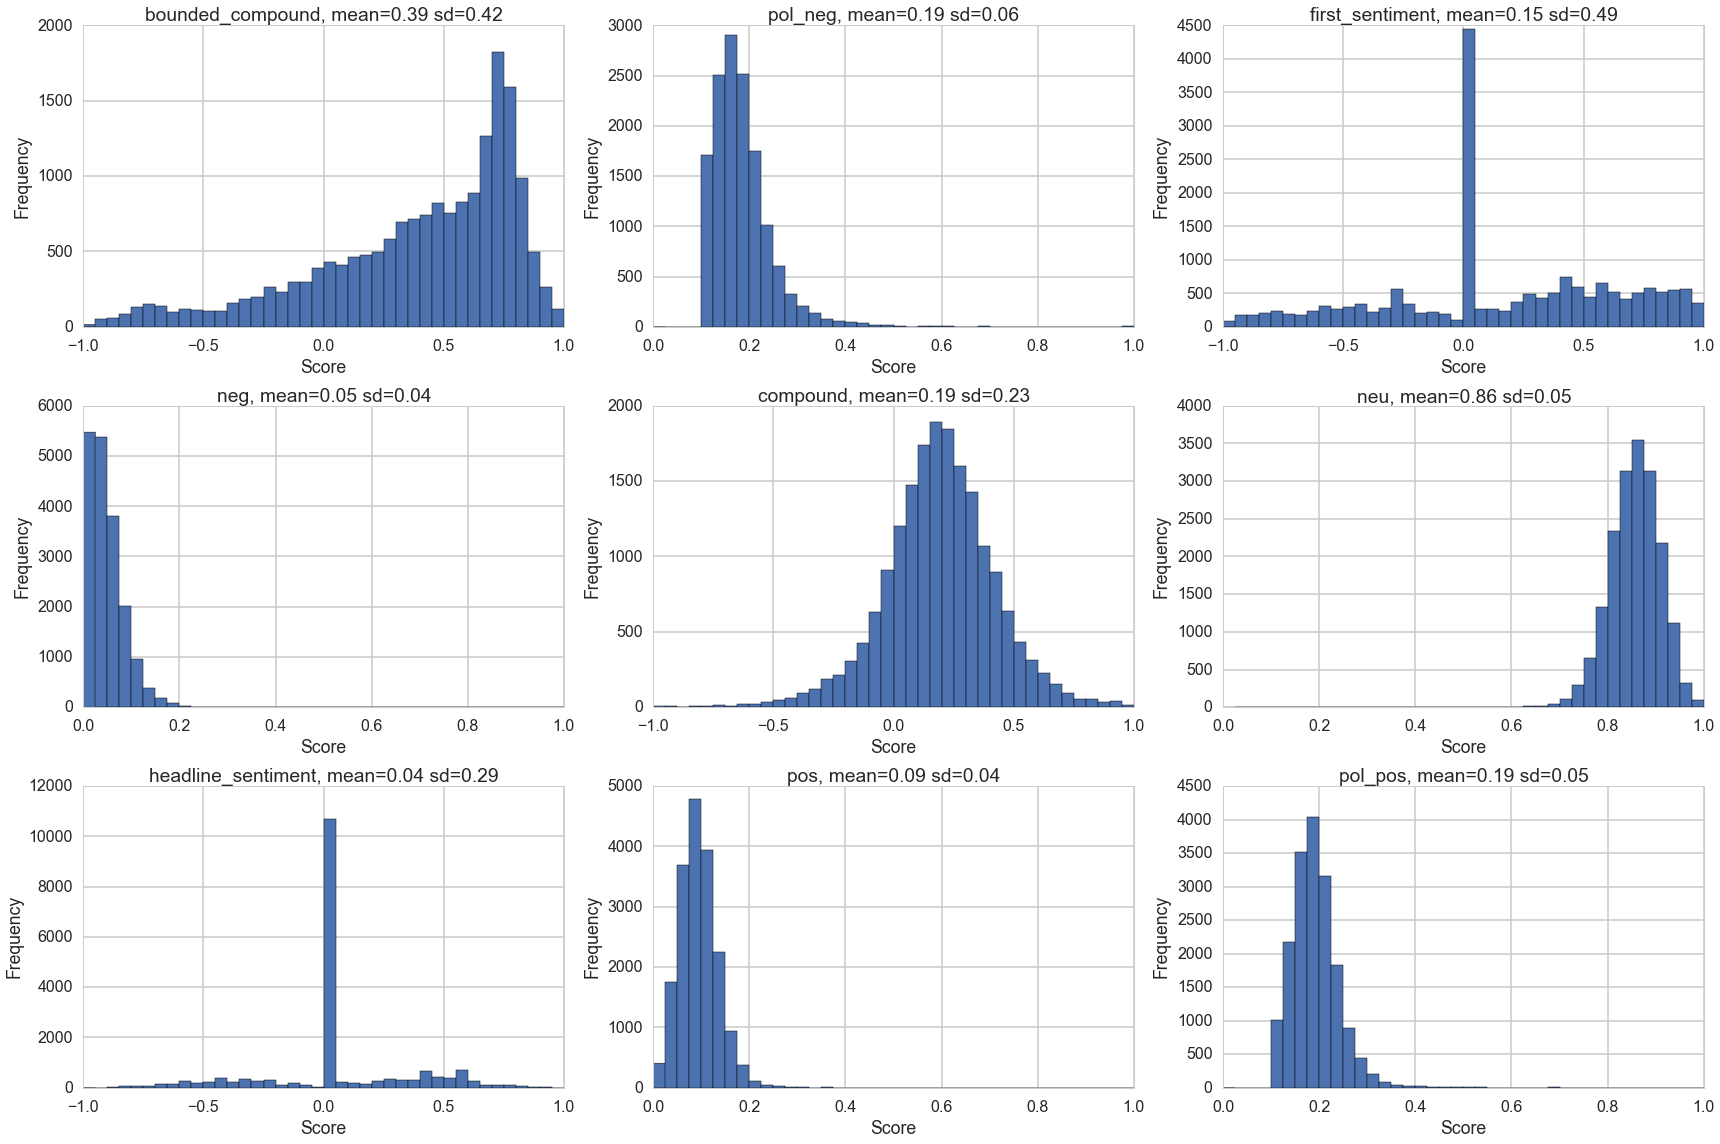

In [19]:
#gathers names of scores (e.g. "pol_pos)
hist_names = [name for name in score_dicts[0][1].keys()]
ncols = 3
nrows = len(hist_names)/ncols
fig, axes = plt.subplots(nrows=nrows, ncols=ncols,tight_layout=True, figsize=(24, 16))
subplot_num = 1
hist_data = []
for name in hist_names:
    hist_list = []
    for info in score_dicts:
        x = info[1][name]
        if x is not None:
            hist_list.append(x)
    hist_data.append(hist_list)
    plt.subplot(nrows,ncols,subplot_num)
    if np.nanmin(hist_list) < 0:
        plt.hist(hist_list, bins=40, range=[-1,1])
    else:
        plt.hist(hist_list, bins=40, range=[0,1])
    plt.xlabel('Score')
    plt.ylabel('Frequency')
    plt.title(name + ', mean=' + str("{0:.2f}".format(np.nanmean(hist_list))) + ' sd=' + str("{0:.2f}".format(np.nanstd(hist_list))))
    subplot_num += 1
plt.show()

1. First sentence sentiment ("first_sentiment") and headline sentiment ("headline_sentiment") appear to be completely neutral most of the time, but biased significantly towards positive sentiment otherwise.

2. Based on the positive and negative histograms ("pos" and "neg"), the Crimson looks to have a positive bias, as the positive histogram is centered more to the right. This is confirmed by the compound score histogram, as it is centered well to the right of zero.

3. Articles with "extreme" sentiment (i.e. absolute value of compound score greater than 0.5) are far more likely to have positive sentiment. The bounded compound plot confirms this observation.

Let's determine the most positive and negative articles based on our findings! Let's also see if pasting the entire article text into NLTK does a better job of determining sentiment.

In [20]:
min_val = 0
max_val = 0
neg_index = 0
pos_index = 0
for info in score_dicts:
    if info[1]['compound'] < min_val:
        min_val = info[1]['compound']
        neg_index = info[0]
    if info[1]['compound'] > max_val:
        max_val = info[1]['compound']
        pos_index = info[0]
        
print "Most Negative Article!"
print articledf.iloc[neg_index]
print
print "Most Positive Article!"
print articledf.iloc[pos_index]


Most Negative Article!
body        America currently faces a bullying crisis, acc...
date                                               2012-02-16
day                                                        16
headline                      Ed School Screens Bullying Film
month                                                      02
section                                                  News
tags                                              [Ed School]
url         http://www.thecrimson.com/article/2012/2/16/ed...
year                                                     2012
Name: 15872, dtype: object

Most Positive Article!
body        Commander of the Joint Forces Command General ...
date                                               2011-03-10
day                                                        10
headline                   General: Coalition Needed in Libya
month                                                      03
section                                                  N

These articles make sense. Let's compare our sentiment scores to the score of the article as a whole as calculated by NLTK.

First off, here are our scores of the articles:

In [21]:
print "Most Positive Article"
print score_dicts[pos_index][1]
print
print "Most Negative Article"
print score_dicts[neg_index][1]

Most Positive Article
{'bounded_compound': 0.99670000000000003, 'pol_neg': nan, 'first_sentiment': 0.9967, 'neg': 0.031, 'compound': 0.99670000000000003, 'neu': 0.81100000000000005, 'headline_sentiment': 0.0, 'pos': 0.158, 'pol_pos': 0.158}

Most Negative Article
{'bounded_compound': -0.99260000000000004, 'pol_neg': 0.191, 'first_sentiment': -0.9926, 'neg': 0.191, 'compound': -0.99260000000000004, 'neu': 0.73399999999999999, 'headline_sentiment': -0.59940000000000004, 'pos': 0.074999999999999997, 'pol_pos': nan}


Here are the scores given by the NLTK tool referenced above when pasting in the entire article text:

<img src="http://i.imgur.com/25jIt3N.png" title="source: imgur.com" /></a>

<img src="http://i.imgur.com/w1XgyoR.png" title="source: imgur.com" /></a>

Clearly we do a better job. The full text approach calls both of the articles strongly neutral.

Assuming 10 articles released per day for 350 days a year, the Crimson publishes 3,500 articles
every year. For five years, there should be roughly 17,500 articles published. Let's calculate the actual number.

In [22]:
print "Total Number of Articles 2011-2015"
print len(hist_list)

Total Number of Articles 2011-2015
18331


Let's backup our data and make sure it can be retrieved.

In [3]:
# Backup Creating and Retrieving functions
# Credit to https://gist.github.com/mikedewar/1486027 for the to_json function
def to_json(df,filename):
    d = [ 
        dict([
            (colname, row[i]) 
            for i,colname in enumerate(df.columns)
        ])
        for row in df.values
    ]
    return json.dump(d, open(filename, 'w'))

def from_json(filename):
    fd = open(filename)
    dicts = json.load(fd)
    fd.close()
    return pd.DataFrame(d for d in dicts)

Let's add the score_dicts information to our original dataframe.

In [24]:
# backup stored/retrieved here if needed
#scoredf = from_json('backup_df.json')
df1 = pd.DataFrame(data=[info[1] for info in score_dicts], index=[info[0] for info in score_dicts])
scoredf = pd.concat([articledf, df1], axis=1)
#to_json(scoredf,'backup_df.json')
scoredf.head(5)

,body,date,day,headline,month,section,tags,url,year,bounded_compound,compound,first_sentiment,headline_sentiment,neg,neu,pol_neg,pol_pos,pos
0,Olivia R. Miller '16 and Tess V. Davison '16 ...,2015-09-13,13,"Women Audition for Pudding Cast, But It Will S...",09,News,"[College, On Campus, Student Groups, College L...",http://www.thecrimson.com/article/2015/9/13/wo...,2015,0.314500,0.216506,0.0000,0.0000,0.034750,0.890813,NaN,0.156200,0.074375
1,"UPDATED: September 12, 2015, at 5:00 p.m. Luke...",2015-09-13,13,Lowell Sophomore Dies ‘Suddenly and Unexpectedly’,09,News,"[College, Breaking News, Lowell, College News]",http://www.thecrimson.com/article/2015/9/13/lo...,2015,-0.679500,-0.186367,-0.5574,0.0000,0.048667,0.932444,0.182500,0.106000,0.018889
2,Longtime Harvard Management Company investor A...,2015-09-13,13,Wiltshire Will Leave Harvard Management Company,09,News,"[Central Administration, Endowment, University...",http://www.thecrimson.com/article/2015/9/13/wi...,2015,-0.636900,-0.006180,0.4939,-0.0516,0.048400,0.900600,0.179500,0.127667,0.051100
3,"UPDATED: September 15, 2015, at 4:51 a.m.Speak...",2015-09-13,13,Luke Tang ’18 Lived a Life of Faith and Empathy,09,News,"[College, Student Life, College Life, Obituary...",http://www.thecrimson.com/article/2015/9/13/lu...,2015,0.099914,0.139879,-0.6908,0.4215,0.035632,0.887368,0.145750,0.146714,0.077000
4,Yes QueenTerrorism is defined by Merriam-Webst...,2015-09-12,12,Protecting Providers,09,Opinion,[Columns],http://www.thecrimson.com/column/yes-queen/art...,2015,-0.591756,-0.395143,-0.1779,0.0000,0.199867,0.724033,0.282524,0.177000,0.076067


Let's check how many articles we have in total.

In [25]:
scoredf.shape[0]

18331

How many articles are in each section?

In [26]:
sections = list(set(scoredf['section'].get_values()))
article_sum = 0
for section in sections:
    print section
    count = scoredf[scoredf['section'] == section].shape[0]
    print str(count)
    print
    article_sum += count
print "Total"
print article_sum

Arts
2515

Multimedia
1

Sports
4364

Magazine
1515

Opinion
3077

News
6859

Total
18331


Let's clean up the data a bit. We used <a href=http://www.icwsm.org/papers/3--Godbole-Srinivasaiah-Skiena.pdf>this paper</a> and <a href=http://nlp.stanford.edu/courses/cs224n/2011/reports/nccohen-aatreya-jameszjj.pdf>this paper</a> as inspiration for some of the variables we calculated.

We will start with the date columns.

In [27]:
date = scoredf['date'].get_values()[0]
print date
print
#some problematic dates, truncate dates to date[0:10] as a result, example
print sorted(set(scoredf['date'].get_values()))[-1]

2015-09-13

2015-12-07T02:40:33


In [28]:
#some days are problematic, truncate to fix, example
sorted(set(scoredf['day'].get_values()))[8]

u'06T22:08:09'

Let's add columns for the day, month, and year as integers.

In [29]:
#add int day/month columns
days = [{"int_day":int(day[0:2])} for day in scoredf['day'].get_values()]
daydf = pd.DataFrame(days)
months = [{"int_month":int(month[0:2])} for month in scoredf['month'].get_values()]
monthdf = pd.DataFrame(months)
scoredf = pd.concat([scoredf, daydf, monthdf], axis=1)
scoredf.head(5)

,body,date,day,headline,month,section,tags,url,year,bounded_compound,compound,first_sentiment,headline_sentiment,neg,neu,pol_neg,pol_pos,pos,int_day,int_month
0,Olivia R. Miller '16 and Tess V. Davison '16 ...,2015-09-13,13,"Women Audition for Pudding Cast, But It Will S...",09,News,"[College, On Campus, Student Groups, College L...",http://www.thecrimson.com/article/2015/9/13/wo...,2015,0.314500,0.216506,0.0000,0.0000,0.034750,0.890813,NaN,0.156200,0.074375,13,9
1,"UPDATED: September 12, 2015, at 5:00 p.m. Luke...",2015-09-13,13,Lowell Sophomore Dies ‘Suddenly and Unexpectedly’,09,News,"[College, Breaking News, Lowell, College News]",http://www.thecrimson.com/article/2015/9/13/lo...,2015,-0.679500,-0.186367,-0.5574,0.0000,0.048667,0.932444,0.182500,0.106000,0.018889,13,9
2,Longtime Harvard Management Company investor A...,2015-09-13,13,Wiltshire Will Leave Harvard Management Company,09,News,"[Central Administration, Endowment, University...",http://www.thecrimson.com/article/2015/9/13/wi...,2015,-0.636900,-0.006180,0.4939,-0.0516,0.048400,0.900600,0.179500,0.127667,0.051100,13,9
3,"UPDATED: September 15, 2015, at 4:51 a.m.Speak...",2015-09-13,13,Luke Tang ’18 Lived a Life of Faith and Empathy,09,News,"[College, Student Life, College Life, Obituary...",http://www.thecrimson.com/article/2015/9/13/lu...,2015,0.099914,0.139879,-0.6908,0.4215,0.035632,0.887368,0.145750,0.146714,0.077000,13,9
4,Yes QueenTerrorism is defined by Merriam-Webst...,2015-09-12,12,Protecting Providers,09,Opinion,[Columns],http://www.thecrimson.com/column/yes-queen/art...,2015,-0.591756,-0.395143,-0.1779,0.0000,0.199867,0.724033,0.282524,0.177000,0.076067,12,9


In [30]:
#add year as int column
years = [{"int_year":int(year[0:4])} for year in scoredf['year'].get_values()]
yeardf = pd.DataFrame(years)
scoredf = pd.concat([scoredf, yeardf], axis=1)
scoredf.head(5)

,body,date,day,headline,month,section,tags,url,year,bounded_compound,...,first_sentiment,headline_sentiment,neg,neu,pol_neg,pol_pos,pos,int_day,int_month,int_year
0,Olivia R. Miller '16 and Tess V. Davison '16 ...,2015-09-13,13,"Women Audition for Pudding Cast, But It Will S...",09,News,"[College, On Campus, Student Groups, College L...",http://www.thecrimson.com/article/2015/9/13/wo...,2015,0.314500,...,0.0000,0.0000,0.034750,0.890813,NaN,0.156200,0.074375,13,9,2015
1,"UPDATED: September 12, 2015, at 5:00 p.m. Luke...",2015-09-13,13,Lowell Sophomore Dies ‘Suddenly and Unexpectedly’,09,News,"[College, Breaking News, Lowell, College News]",http://www.thecrimson.com/article/2015/9/13/lo...,2015,-0.679500,...,-0.5574,0.0000,0.048667,0.932444,0.182500,0.106000,0.018889,13,9,2015
2,Longtime Harvard Management Company investor A...,2015-09-13,13,Wiltshire Will Leave Harvard Management Company,09,News,"[Central Administration, Endowment, University...",http://www.thecrimson.com/article/2015/9/13/wi...,2015,-0.636900,...,0.4939,-0.0516,0.048400,0.900600,0.179500,0.127667,0.051100,13,9,2015
3,"UPDATED: September 15, 2015, at 4:51 a.m.Speak...",2015-09-13,13,Luke Tang ’18 Lived a Life of Faith and Empathy,09,News,"[College, Student Life, College Life, Obituary...",http://www.thecrimson.com/article/2015/9/13/lu...,2015,0.099914,...,-0.6908,0.4215,0.035632,0.887368,0.145750,0.146714,0.077000,13,9,2015
4,Yes QueenTerrorism is defined by Merriam-Webst...,2015-09-12,12,Protecting Providers,09,Opinion,[Columns],http://www.thecrimson.com/column/yes-queen/art...,2015,-0.591756,...,-0.1779,0.0000,0.199867,0.724033,0.282524,0.177000,0.076067,12,9,2015


Perhaps the day of the week (dow) correlates with scores, so let's use datetime to find the day of the week for each date as a 0-6 int.

In [31]:
#add day of week (dow) column
dow = [{"dow":int(datetime.datetime.strptime(date[0:10], '%Y-%m-%d').strftime('%w'))} \
       for date in scoredf['date'].get_values()]
scoredf = pd.concat([scoredf, pd.DataFrame(dow)], axis=1)

In [32]:
#scoredf = scoredf.drop('dow', axis=1)

In [33]:
scoredf.head(5)

,body,date,day,headline,month,section,tags,url,year,bounded_compound,...,headline_sentiment,neg,neu,pol_neg,pol_pos,pos,int_day,int_month,int_year,dow
0,Olivia R. Miller '16 and Tess V. Davison '16 ...,2015-09-13,13,"Women Audition for Pudding Cast, But It Will S...",09,News,"[College, On Campus, Student Groups, College L...",http://www.thecrimson.com/article/2015/9/13/wo...,2015,0.314500,...,0.0000,0.034750,0.890813,NaN,0.156200,0.074375,13,9,2015,0
1,"UPDATED: September 12, 2015, at 5:00 p.m. Luke...",2015-09-13,13,Lowell Sophomore Dies ‘Suddenly and Unexpectedly’,09,News,"[College, Breaking News, Lowell, College News]",http://www.thecrimson.com/article/2015/9/13/lo...,2015,-0.679500,...,0.0000,0.048667,0.932444,0.182500,0.106000,0.018889,13,9,2015,0
2,Longtime Harvard Management Company investor A...,2015-09-13,13,Wiltshire Will Leave Harvard Management Company,09,News,"[Central Administration, Endowment, University...",http://www.thecrimson.com/article/2015/9/13/wi...,2015,-0.636900,...,-0.0516,0.048400,0.900600,0.179500,0.127667,0.051100,13,9,2015,0
3,"UPDATED: September 15, 2015, at 4:51 a.m.Speak...",2015-09-13,13,Luke Tang ’18 Lived a Life of Faith and Empathy,09,News,"[College, Student Life, College Life, Obituary...",http://www.thecrimson.com/article/2015/9/13/lu...,2015,0.099914,...,0.4215,0.035632,0.887368,0.145750,0.146714,0.077000,13,9,2015,0
4,Yes QueenTerrorism is defined by Merriam-Webst...,2015-09-12,12,Protecting Providers,09,Opinion,[Columns],http://www.thecrimson.com/column/yes-queen/art...,2015,-0.591756,...,0.0000,0.199867,0.724033,0.282524,0.177000,0.076067,12,9,2015,6


Perhaps the week number in the year (0-51) correlates with scores, so let's add it as well.

In [34]:
#add week number, e.g. week 37 of a 52 week year
weeknum = [{"weeknum":int(datetime.datetime.strptime(date[0:10], '%Y-%m-%d').strftime('%W'))} for date in scoredf['date'].get_values()]
scoredf = pd.concat([scoredf, pd.DataFrame(weeknum)], axis=1)
scoredf.head(5)

,body,date,day,headline,month,section,tags,url,year,bounded_compound,...,neg,neu,pol_neg,pol_pos,pos,int_day,int_month,int_year,dow,weeknum
0,Olivia R. Miller '16 and Tess V. Davison '16 ...,2015-09-13,13,"Women Audition for Pudding Cast, But It Will S...",09,News,"[College, On Campus, Student Groups, College L...",http://www.thecrimson.com/article/2015/9/13/wo...,2015,0.314500,...,0.034750,0.890813,NaN,0.156200,0.074375,13,9,2015,0,36
1,"UPDATED: September 12, 2015, at 5:00 p.m. Luke...",2015-09-13,13,Lowell Sophomore Dies ‘Suddenly and Unexpectedly’,09,News,"[College, Breaking News, Lowell, College News]",http://www.thecrimson.com/article/2015/9/13/lo...,2015,-0.679500,...,0.048667,0.932444,0.182500,0.106000,0.018889,13,9,2015,0,36
2,Longtime Harvard Management Company investor A...,2015-09-13,13,Wiltshire Will Leave Harvard Management Company,09,News,"[Central Administration, Endowment, University...",http://www.thecrimson.com/article/2015/9/13/wi...,2015,-0.636900,...,0.048400,0.900600,0.179500,0.127667,0.051100,13,9,2015,0,36
3,"UPDATED: September 15, 2015, at 4:51 a.m.Speak...",2015-09-13,13,Luke Tang ’18 Lived a Life of Faith and Empathy,09,News,"[College, Student Life, College Life, Obituary...",http://www.thecrimson.com/article/2015/9/13/lu...,2015,0.099914,...,0.035632,0.887368,0.145750,0.146714,0.077000,13,9,2015,0,36
4,Yes QueenTerrorism is defined by Merriam-Webst...,2015-09-12,12,Protecting Providers,09,Opinion,[Columns],http://www.thecrimson.com/column/yes-queen/art...,2015,-0.591756,...,0.199867,0.724033,0.282524,0.177000,0.076067,12,9,2015,6,36


In [35]:
#scoredf = scoredf.drop('int_year', axis=1)

OK, at this point it looks like all of our data is organized and cleaned. We will start with regression to analyze our data.

#Linear Regression

Using the Seaborn library, one can easily construct scatterplot grids to explore the relationships between all of our variables. Here, we remove rows with any NaN data. Typically NaNs come from the polarized and bounded scores, as the calculation of these scores sometimes leads to trying to take a mean of no data (e.g. when there are no positive scores above 0.1 in an article). Bear in mind that there isn't a lot of NaN data and that this exercise is simply exploratory. Later regression in this section will remove NaNs more effectively.

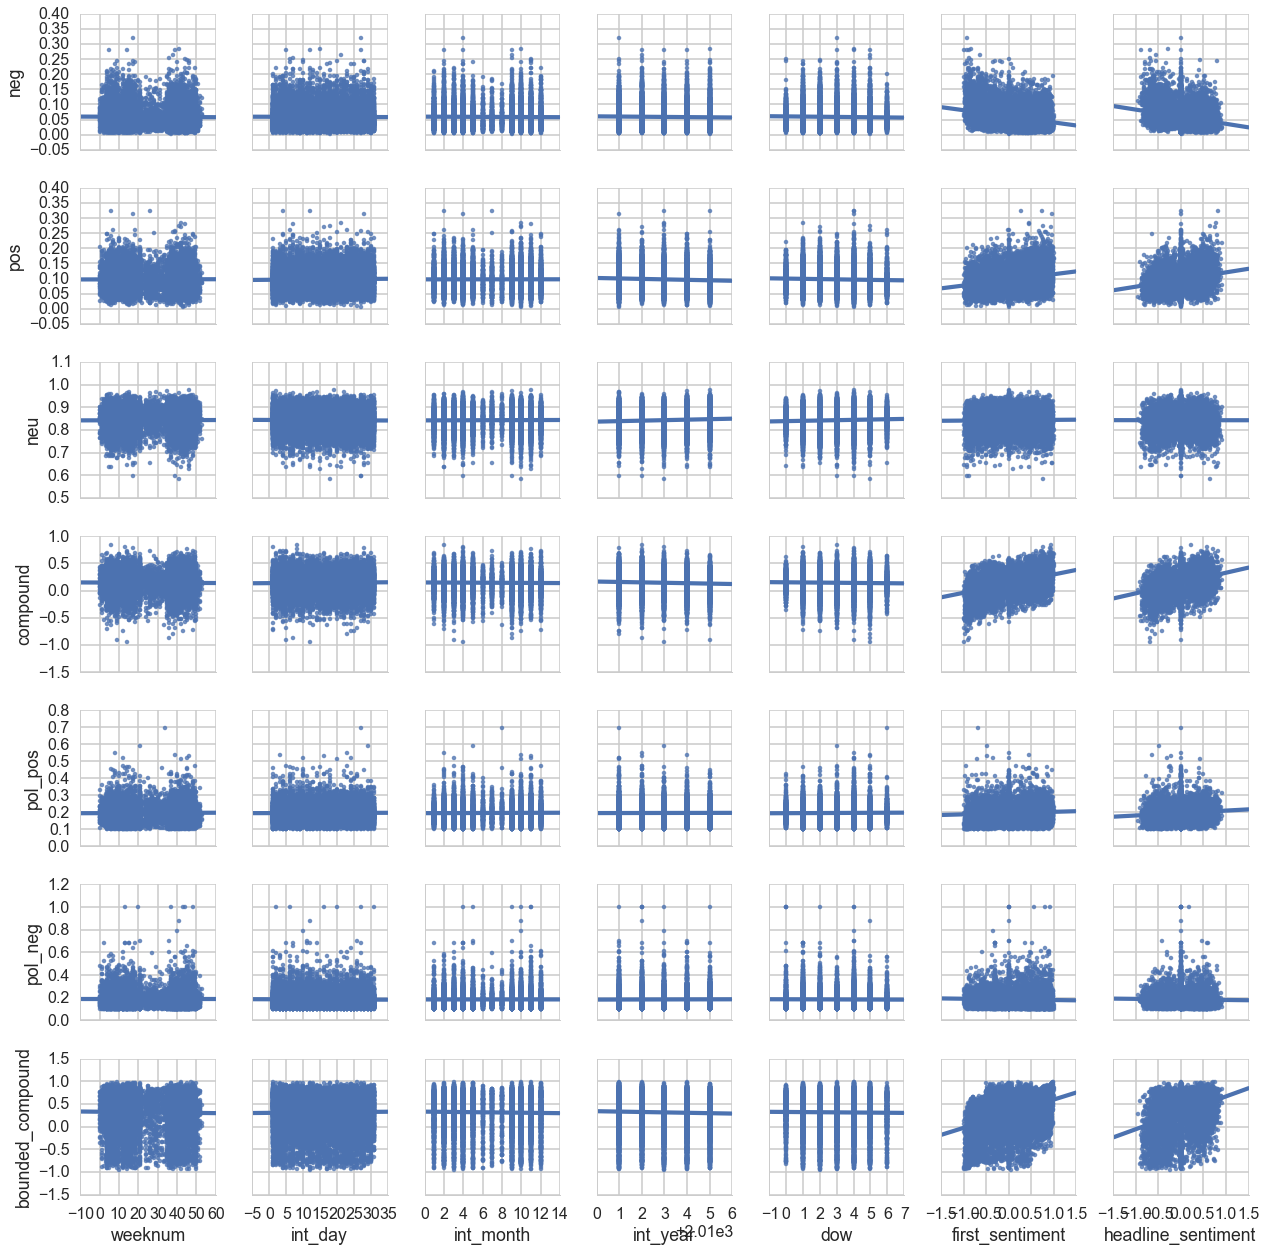

In [36]:
#Make some simple scatterplots with regression lines to determine if regression is useful for any two variables
mask = scoredf.dropna(subset=['neg','pos','neu','compound','pol_pos','pol_neg','bounded_compound'], how='any')

#Make a beautful seaborn pairplot with the desired variables
sns.pairplot(mask, x_vars=['weeknum','int_day','int_month', 'int_year', 'dow', 'first_sentiment', 'headline_sentiment'], \
                            y_vars=['neg','pos','neu','compound','pol_pos','pol_neg','bounded_compound'], kind='reg')



Note: from this point forward, we will always use compound score as our dependent variable.

Some observations:

* Weeknum, int_day, and int_month do not look like a powerful predictors of any scores.
* int_year and dow appear to have a weak effect on scores.
* First sentence compound sentiment score looks like it correlates with compound and bounded compound score!
* Headline compound sentiment also looks to have an effect on compound and bounded compound score!

Let's split to train and test sets for our analysis.

In [37]:
#Split to test and train sets for future analysis
traindf, testdf = train_test_split(scoredf, test_size = 0.2)

Now for some exploratory regressions. The end goal of this process is to find a simple regression formula that has a relatively high R-squared. Let's start with the year as a predictor. Note that wrapping a variable with C() in a formula classfies it as categorical.

The year model explains 0.8% of the variation in compound score.

In [38]:
#year looks to be a weak predictor of compound score
ols_model = ols('compound ~ C(int_year)', data=traindf).fit()
ols_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               compound   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     27.65
Date:                Thu, 10 Dec 2015   Prob (F-statistic):           6.65e-23
Time:                        20:52:18   Log-Likelihood:                 833.03
No. Observations:               14662   AIC:                            -1656.
Df Residuals:                   14657   BIC:                            -1618.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------
Intercept               0.2106      0.004     53.228      0.000         0.203     0.218
C(int_year)[T.2012]    -0.0018      0.006     -0.308      0.758        -0.013     0.009
C(int_year)[T.2013]    -0.0157      0.006     -2.743      0.006        -0.027    -0.004
C(int_year)[T.2014]    -0.0348      0.006     -5.883      0.000        -0.046    -0.023
C(int_year)[T.2015]    -0.0536      0.006     -8.824      0.000        -0.066    -0.042
==============================================================================
Omnibus:                      677.415   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1575.027
Skew:                          -0.286   Prob(JB):                         0.00
Kurtosis:                       4.501   Cond. No.                         5.52
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Let's try dow as a predictor.

The dow model explains 0.2% of the variation in compound score.

In [39]:
#dow (as a categorical variable) is also not a strong predictor of compound score
ols_model = ols('compound ~ C(dow)', data=traindf).fit()
ols_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               compound   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     5.880
Date:                Thu, 10 Dec 2015   Prob (F-statistic):           3.86e-06
Time:                        20:52:18   Log-Likelihood:                 795.55
No. Observations:               14662   AIC:                            -1577.
Df Residuals:                   14655   BIC:                            -1524.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
Intercept       0.2032      0.009     23.538      0.000         0.186     0.220
C(dow)[T.1]     0.0052      0.010      0.535      0.593        -0.014     0.024
C(dow)[T.2]    -0.0137      0.010     -1.434      0.152        -0.032     0.005
C(dow)[T.3]    -0.0156      0.010     -1.582      0.114        -0.035     0.004
C(dow)[T.4]    -0.0221      0.010     -2.310      0.021        -0.041    -0.003
C(dow)[T.5]    -0.0061      0.010     -0.623      0.533        -0.025     0.013
C(dow)[T.6]    -0.0470      0.014     -3.411      0.001        -0.074    -0.020
==============================================================================
Omnibus:                      610.309   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1448.572
Skew:                          -0.243   Prob(JB):                         0.00
Kurtosis:                       4.461   Cond. No.                         13.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Let's try newspaper section as a predictor.

The year model explains 4.3% of the variation in compound score. Pretty good!

In [40]:
#Article section of newspaper looks to have a moderate effect on compound score!
ols_model = ols('compound ~ section', data=traindf).fit()
ols_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               compound   R-squared:                       0.044
Model:                            OLS   Adj. R-squared:                  0.044
Method:                 Least Squares   F-statistic:                     135.1
Date:                Thu, 10 Dec 2015   Prob (F-statistic):          1.65e-140
Time:                        20:52:18   Log-Likelihood:                 1108.3
No. Observations:               14662   AIC:                            -2205.
Df Residuals:                   14656   BIC:                            -2159.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------
Intercept                 0.1686      0.005     33.509      0.000         0.159     0.178
section[T.Magazine]      -0.0223      0.008     -2.718      0.007        -0.038    -0.006
section[T.Multimedia]    -0.2514      0.224     -1.120      0.263        -0.691     0.189
section[T.News]           0.0622      0.006     10.581      0.000         0.051     0.074
section[T.Opinion]       -0.0649      0.007     -9.602      0.000        -0.078    -0.052
section[T.Sports]         0.0520      0.006      8.285      0.000         0.040     0.064
==============================================================================
Omnibus:                      986.660   Durbin-Watson:                   2.010
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2389.597
Skew:                          -0.412   Prob(JB):                         0.00
Kurtosis:                       4.798   Cond. No.                         135.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Let's try first sentence sentiment as a predictor.

The year model explains 29% of the variation in compound score. Awesome!

In [41]:
#first sentence compound sentiment score looks to be a strong predictor of compound score!
ols_model = ols('compound ~ first_sentiment', data=traindf).fit()
ols_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               compound   R-squared:                       0.290
Model:                            OLS   Adj. R-squared:                  0.290
Method:                 Least Squares   F-statistic:                     5990.
Date:                Thu, 10 Dec 2015   Prob (F-statistic):               0.00
Time:                        20:52:18   Log-Likelihood:                 3289.6
No. Observations:               14662   AIC:                            -6575.
Df Residuals:                   14660   BIC:                            -6560.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
Intercept           0.1524      0.002     90.975      0.000         0.149     0.156
first_sentiment     0.2545      0.003     77.398      0.000         0.248     0.261
==============================================================================
Omnibus:                      251.351   Durbin-Watson:                   2.019
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              348.427
Skew:                          -0.215   Prob(JB):                     2.19e-76
Kurtosis:                       3.621   Cond. No.                         2.12
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Let's try headline sentiment score a predictor.

The year model explains 10.4% of the variation in compound score. Also great!

In [42]:
#headline compound sentiment score looks to be a strong predictor of compound score!
ols_model = ols('compound ~ headline_sentiment', data=traindf).fit()
ols_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               compound   R-squared:                       0.106
Model:                            OLS   Adj. R-squared:                  0.106
Method:                 Least Squares   F-statistic:                     1742.
Date:                Thu, 10 Dec 2015   Prob (F-statistic):               0.00
Time:                        20:52:18   Log-Likelihood:                 1600.8
No. Observations:               14662   AIC:                            -3198.
Df Residuals:                   14660   BIC:                            -3182.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------
Intercept              0.1807      0.002     99.802      0.000         0.177     0.184
headline_sentiment     0.2549      0.006     41.731      0.000         0.243     0.267
==============================================================================
Omnibus:                      459.096   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1110.584
Skew:                          -0.138   Prob(JB):                    6.92e-242
Kurtosis:                       4.320   Cond. No.                         3.42
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Combining the two strongest models leads to a higher R^2 than either of the two models, but it does look like some of the first sentence sentiment effect is captured by headline sentiment effect, as the combined R^2 is not simply the sum of each model's R^2s.

This combination model explains 32.5% of the variation in compound score.

In [43]:
#Some of the headline sentiment effect is explained by the first sentence sentiment
ols_model = ols('compound ~ headline_sentiment + first_sentiment', data=traindf).fit()
ols_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               compound   R-squared:                       0.326
Model:                            OLS   Adj. R-squared:                  0.326
Method:                 Least Squares   F-statistic:                     3546.
Date:                Thu, 10 Dec 2015   Prob (F-statistic):               0.00
Time:                        20:52:18   Log-Likelihood:                 3670.9
No. Observations:               14662   AIC:                            -7336.
Df Residuals:                   14659   BIC:                            -7313.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------
Intercept              0.1496      0.002     91.507      0.000         0.146     0.153
headline_sentiment     0.1539      0.006     27.972      0.000         0.143     0.165
first_sentiment        0.2298      0.003     69.157      0.000         0.223     0.236
==============================================================================
Omnibus:                      221.204   Durbin-Watson:                   2.015
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              326.467
Skew:                          -0.173   Prob(JB):                     1.28e-71
Kurtosis:                       3.644   Cond. No.                         3.66
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Adding section into our model raises the R-squared even more, but again not by the entire R-squared of the section predictor alone. Thus, some of the section influence is explained by the headline and first sentence effect.

This combination model explains 35% of the variation in compound score of the entire article!

In [44]:
ols_model = ols('compound ~ headline_sentiment + first_sentiment + section', data=traindf).fit()
ols_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               compound   R-squared:                       0.348
Model:                            OLS   Adj. R-squared:                  0.348
Method:                 Least Squares   F-statistic:                     1118.
Date:                Thu, 10 Dec 2015   Prob (F-statistic):               0.00
Time:                        20:52:18   Log-Likelihood:                 3914.4
No. Observations:               14662   AIC:                            -7813.
Df Residuals:                   14654   BIC:                            -7752.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------
Intercept                 0.1293      0.004     30.907      0.000         0.121     0.137
section[T.Magazine]      -0.0123      0.007     -1.818      0.069        -0.026     0.001
section[T.Multimedia]    -0.3143      0.185     -1.696      0.090        -0.678     0.049
section[T.News]           0.0527      0.005     10.843      0.000         0.043     0.062
section[T.Opinion]       -0.0372      0.006     -6.653      0.000        -0.048    -0.026
section[T.Sports]         0.0382      0.005      7.362      0.000         0.028     0.048
headline_sentiment        0.1514      0.005     27.866      0.000         0.141     0.162
first_sentiment           0.2227      0.003     67.783      0.000         0.216     0.229
==============================================================================
Omnibus:                      387.606   Durbin-Watson:                   2.016
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              597.622
Skew:                          -0.267   Prob(JB):                    1.69e-130
Kurtosis:                       3.833   Cond. No.                         137.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Applying the model to the bounded compound score shows a lower R-squared of 26.8%.

In [45]:
ols_model = ols('bounded_compound ~ headline_sentiment + first_sentiment + section', data=traindf).fit()
ols_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       bounded_compound   R-squared:                       0.269
Model:                            OLS   Adj. R-squared:                  0.269
Method:                 Least Squares   F-statistic:                     759.4
Date:                Thu, 10 Dec 2015   Prob (F-statistic):               0.00
Time:                        20:52:19   Log-Likelihood:                -5726.5
No. Observations:               14419   AIC:                         1.147e+04
Df Residuals:                   14411   BIC:                         1.153e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------
Intercept                 0.2952      0.008     36.154      0.000         0.279     0.311
section[T.Magazine]       0.0294      0.013      2.195      0.028         0.003     0.056
section[T.Multimedia]    -0.9816      0.360     -2.726      0.006        -1.688    -0.276
section[T.News]           0.0501      0.010      5.265      0.000         0.031     0.069
section[T.Opinion]       -0.0887      0.011     -8.129      0.000        -0.110    -0.067
section[T.Sports]         0.0857      0.010      8.465      0.000         0.066     0.106
headline_sentiment        0.2680      0.011     25.300      0.000         0.247     0.289
first_sentiment           0.3446      0.006     53.825      0.000         0.332     0.357
==============================================================================
Omnibus:                     1330.775   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1726.595
Skew:                          -0.817   Prob(JB):                         0.00
Kurtosis:                       3.449   Cond. No.                         136.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Let's now apply our best models to the test set of data. Unfortunately it is very complicated to perform prediction on a test set with statsmodel.object.predict if a categorical variable is involved (e.g. section), so we will use the model without the section component. The R-Squared of the headline and first sentence model is only 2.5% or so lower than the model with section as well, so it still should be pretty valid.

The root mean squared error in compound score is 0.191140614347


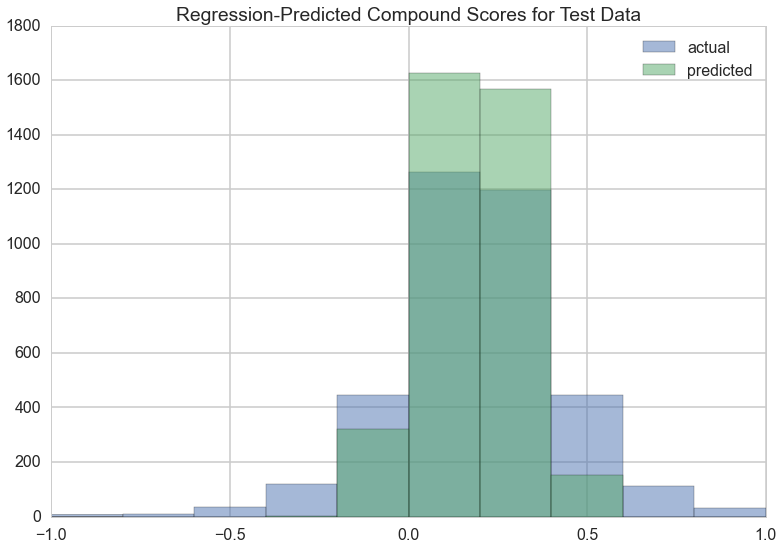

In [46]:
ols_model = ols('compound ~ headline_sentiment + first_sentiment', data=traindf).fit()
df_test = pd.concat([testdf['headline_sentiment'], testdf['first_sentiment']], axis=1)
#calculate predicted scores of the test set
test_scores = ols_model.predict(add_constant(df_test), transform=False)

actual = [score for score in testdf['compound'].get_values() if not np.isnan(score)]
predicted = [score for score in test_scores if not np.isnan(score)]

#calculate RMSE
RMSE = np.sqrt(mean_squared_error(actual, predicted))
print "The root mean squared error in compound score is " + str(RMSE)
bins=[-1, -0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1.0]
plt.hist(actual, bins=bins, alpha=0.5, label='actual')
plt.hist(predicted, bins=bins, alpha=0.5, label='predicted')
plt.legend()
plt.title("Regression-Predicted Compound Scores for Test Data")
plt.show()

The histogram and relatively low RMSE show that we did a decent job of predicting scores with our regression model. Perhaps more advanced modeling (random forest perhaps?) could do a better job.

In [47]:
# Uncomment to store backup
#to_json(scoredf,'backup_df2.json')
#Check if stored
#scoredf2 = from_json('backup_df2.json')
#scoredf2.head(5)

Let's store our predicted values for all of our data in the dataframe just in case we want to use them later.

In [48]:
df = pd.concat([scoredf['headline_sentiment'], scoredf['first_sentiment']], axis=1)
predicted_scores = ols_model.predict(add_constant(df), transform=False)
#Should be 18331
len(predicted_scores)

18331

In [49]:
predicted_df = pd.DataFrame({'predicted_compound':predicted_scores})
fulldf = pd.concat([scoredf, predicted_df], axis=1)
to_json(fulldf, 'analyzed_articles.json')
fulldf.head(5)

,body,date,day,headline,month,section,tags,url,year,bounded_compound,...,neu,pol_neg,pol_pos,pos,int_day,int_month,int_year,dow,weeknum,predicted_compound
0,Olivia R. Miller '16 and Tess V. Davison '16 ...,2015-09-13,13,"Women Audition for Pudding Cast, But It Will S...",09,News,"[College, On Campus, Student Groups, College L...",http://www.thecrimson.com/article/2015/9/13/wo...,2015,0.314500,...,0.890813,NaN,0.156200,0.074375,13,9,2015,0,36,0.149631
1,"UPDATED: September 12, 2015, at 5:00 p.m. Luke...",2015-09-13,13,Lowell Sophomore Dies ‘Suddenly and Unexpectedly’,09,News,"[College, Breaking News, Lowell, College News]",http://www.thecrimson.com/article/2015/9/13/lo...,2015,-0.679500,...,0.932444,0.182500,0.106000,0.018889,13,9,2015,0,36,0.021518
2,Longtime Harvard Management Company investor A...,2015-09-13,13,Wiltshire Will Leave Harvard Management Company,09,News,"[Central Administration, Endowment, University...",http://www.thecrimson.com/article/2015/9/13/wi...,2015,-0.636900,...,0.900600,0.179500,0.127667,0.051100,13,9,2015,0,36,0.255209
3,"UPDATED: September 15, 2015, at 4:51 a.m.Speak...",2015-09-13,13,Luke Tang ’18 Lived a Life of Faith and Empathy,09,News,"[College, Student Life, College Life, Obituary...",http://www.thecrimson.com/article/2015/9/13/lu...,2015,0.099914,...,0.887368,0.145750,0.146714,0.077000,13,9,2015,0,36,0.055716
4,Yes QueenTerrorism is defined by Merriam-Webst...,2015-09-12,12,Protecting Providers,09,Opinion,[Columns],http://www.thecrimson.com/column/yes-queen/art...,2015,-0.591756,...,0.724033,0.282524,0.177000,0.076067,12,9,2015,6,36,0.108742


Regression appears to be a good starting point for our predictive analysis. Let's move on to more advanced modeling and see if we can improve our prediction.

### Random Forest

After doing analysis on our regression model, we decided to see if a more sophisticated machine learning technique would perform better. Looking across possible methods, we ultimately settled on random forest. This technique fits a large group of slightly mutated decision trees to a data set then takes the mean of their results in order to correct for over-fitting.  This seemed like a classification model that would generate effective results because the relative sparsity of our data and breadth of features meant that overfitting was a very real possibility but that decision trees could be very deep and this accurate if that risk was properly controlled for. Furthermore, using sklearn, this technique would be fairly easy to test and manipulate to achieve optimal results. 

We began by building a vocabulary matrix out of our entire training set. We counted the occurrences in each individual headline of words from our overall headline word pool and represented the resulting sums as a vector. We then attempted to run the sklearn random forest classifier on these vectors using 30 random trees parallelized across four cores. Unfortunately, this overwhelmed the 8 GB of memory on our computers.

We initially tried to solve the problem by running our code on Microsoft Azure. This failed because of illegal type conversions that occurred in sklearn source code and made our data unreadable to the server. We then tried to use a very poweful home computer. However, we uncovered a bug in Python itself that made our code incompatible with our processor architecture.

Ultimately, we were forced to pare down our 14,600 element training set to 13,000 elements using random sampling, and this just barely allowed us to generate our random forest on our original machines. In doing this, we discovered that the effectiveness of our models was highly sensitive to changes in sample size. Using 6,000 elements, random forest generated worse results than our original regressions. By 10,000, it looked fairly good. At 13,000, it seemed to fit incredibly well, but the difference between 12,000 and 13,000 suggests that being able to use the full data set would have vastly improved our outcome. 

Additionally, our random forest model RMSE was fairly high at .29 compared to the .19 of the linear regression model. This led us to consider whether RMSE was in fact the right metric to use for evaulating our models, given our visual comparison of the two histograms. Because our new model generated a much wider distribution compared to the more clustered distribution of our regression, there was a significantly greater chance of large errors. This became apparent in our examination of the histograms. Our regressions cleaving to the mean meant that our RMSE was likely to be lower even if the overall quality of our results was worse. 

In [50]:
# import stopwords from NLTK to remove unwanted words such as articles and pronouns from the headlines
# set membership testing is faster than list lookup - convert the stopwords to set 
stopwordset = set(stopwords.words("english")) 

def headlinecleaner(headline):
    # remove non letters from the headline
    cleanerheadline = re.sub("[^a-zA-Z0-9]", " ", headline).lower().split()
    # remove stop words
    headlinewords = [w for w in cleanerheadline if not w in stopwordset]
    # rejoin as a sentence
    headlinecleaned = " ".join(headlinewords)
    headlinecleaned = headlinecleaned.encode('ascii','ignore')
    # return this cleaned result
    return headlinecleaned


In [51]:
# computer runs out of memory for more than 13,000 headlines...
# rows = np.random.choice(traindf.index.values, 13000)
rows = np.random.choice(traindf.index.values, 13000)
sampled_smalldf = traindf.ix[rows]
print sampled_smalldf.shape
# create a list of all of the cleaned headlines
list_of_headlines = sampled_smalldf['headline'].values.tolist()
cleaned_list_of_headlines = [headlinecleaner(x) for x in list_of_headlines]
# create a list of all of the corresponding article sentiment scores
list_of_sentiments = sampled_smalldf['compound'].values

(13000, 23)


In [52]:
%%time
# Bag of Words creation
# initialize
vectorizer = CountVectorizer(analyzer = "word",tokenizer = None, preprocessor = None, stop_words = None,max_features = 20000) 
# fit and learn vocab
# transform training dataset into feature vectors
training_data = vectorizer.fit_transform(cleaned_list_of_headlines)
training_data = training_data.toarray()



CPU times: user 226 ms, sys: 105 ms, total: 331 ms
Wall time: 306 ms


In [53]:
vocab = vectorizer.get_feature_names()
#print vocab

In [54]:
%%time
vocab_distribution = np.sum(training_data, axis=0)
vocab_distribution_scored = zip(vocab, vocab_distribution)
sorted_list = sorted(vocab_distribution_scored, key=lambda e: e[1],reverse=True)
# look at the top frequency vocab words
print sorted_list[0:50]
#for word, count in zip(vocab, vocab_distribution):
#    print count, word

# there looks to be an overwhelming number of sports related fields....

[(u'harvard', 1475), (u'men', 878), (u'women', 757), (u'new', 410), (u'hockey', 389), (u'students', 381), (u'basketball', 347), (u'crimson', 339), (u'school', 246), (u'win', 246), (u'ivy', 237), (u'season', 220), (u'first', 205), (u'year', 203), (u'yale', 176), (u'soccer', 174), (u'falls', 167), (u'uc', 165), (u'college', 163), (u'discusses', 160), (u'student', 160), (u'notebook', 159), (u'two', 158), (u'weekend', 154), (u'title', 151), (u'professor', 142), (u'takes', 141), (u'wins', 141), (u'boston', 135), (u'faculty', 133), (u'university', 125), (u'football', 124), (u'looks', 123), (u'second', 123), (u'princeton', 121), (u'tennis', 121), (u'field', 118), (u'day', 116), (u'victory', 116), (u'volleyball', 114), (u'artist', 112), (u'back', 111), (u'game', 111), (u'house', 109), (u'allston', 108), (u'cambridge', 108), (u'study', 108), (u'square', 107), (u'water', 105), (u'brown', 104)]
CPU times: user 219 ms, sys: 212 ms, total: 430 ms
Wall time: 465 ms


In [55]:
%%time
from sklearn.ensemble import RandomForestClassifier
# initialize random forest classifier with 30 trees
# n_jobs = utilizing multicore cpu - might have to change this for your pc
forest = RandomForestClassifier(n_estimators = 30, n_jobs=4) 
# fit the forest with the training set using the bag of words created
# above as features for the model and the sentiment of the corresponding articles
# as the result values
forest = forest.fit( training_data, list_of_sentiments )

CPU times: user 14min 9s, sys: 24.5 s, total: 14min 33s
Wall time: 3min 55s


In [56]:
# test random headline strings:
dirty_test_data = ['alcohol' \
                   ,'students enjoy cs50' \
                   ,'football team wins the game this weekend'\
                   ,'women discuss loss'
                  ]
clean_test_data = [headlinecleaner(x) for x in dirty_test_data]
print clean_test_data

['alcohol', 'students enjoy cs50', 'football team wins game weekend', 'women discuss loss']


In [57]:
test_data = vectorizer.transform(clean_test_data)
#print test_data

In [58]:
sentscore = forest.predict(test_data)
print sentscore

[ 0.0879129   0.54995714  0.34397778 -0.3235    ]


The root mean squared error in compound score is 0.299320169888


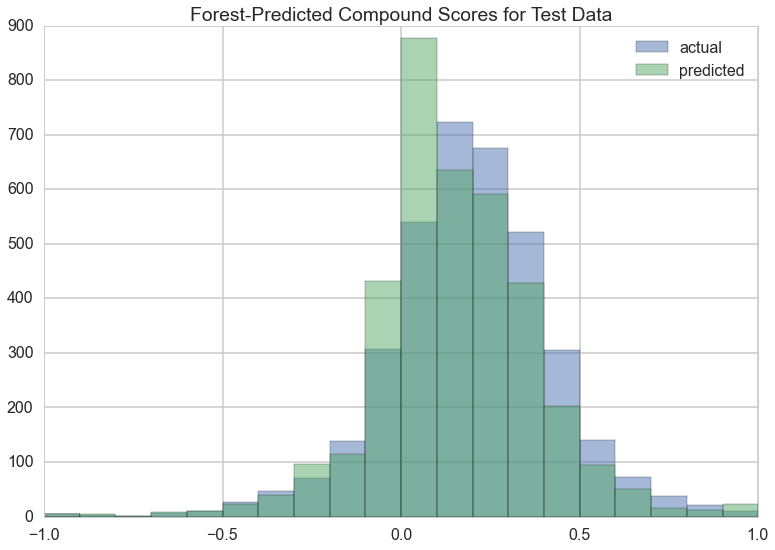

In [59]:
test_list_of_sentiments = testdf['compound'].values
test_list_of_headlines = testdf['headline'].values
predicted_sentiment = forest.predict(vectorizer.transform([headlinecleaner(x) for x in test_list_of_headlines]))
RMSE = np.sqrt(mean_squared_error(test_list_of_sentiments, predicted_sentiment))
print "The root mean squared error in compound score is " + str(RMSE)
bins=[-1, -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
plt.hist(test_list_of_sentiments, bins=bins, alpha=0.5, label='actual')
plt.hist(predicted_sentiment, bins=bins, alpha=0.5, label='predicted')
plt.legend()
plt.title("Forest-Predicted Compound Scores for Test Data")
plt.show()

In [63]:
inter1 = zip(actual, predicted, predicted_sentiment, testdf.section.values)
df2 = pd.DataFrame(inter1, columns=['actual', 'predicted_regression', 'predicted_forest','section'])

#forest_predictions
#to_json(df2, "all_predictions.json")
#df2 = from_json("all_predictions.json")

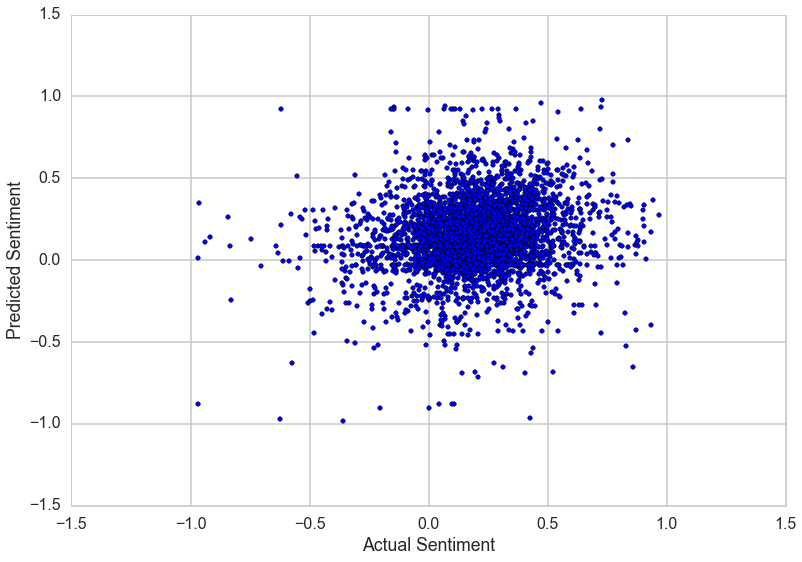

In [7]:
plt.scatter(test_list_of_sentiments,predicted_sentiment)
plt.xlabel("Actual Sentiment")
plt.ylabel("Predicted Sentiment")
plt.show()

The model looks to be somewhat accurate as indicated by the relatively tight cloud of points.

In [62]:
#from sklearn.externals import joblib
#joblib.dump(forest, 'forest.pkl') 
#joblib.dump(vectorizer, 'vectorizer.pkl') 

#then your colleagues can load it

#clf = joblib.load('forest.pk1')

Finally, we uploaded our random forest model to the website in order to create a tool that allows for on the spot predictions of any headline or phrase. See website for details.

###Conclusion and Possible Applications

To conclude, a Crimson headline tells you more than just the topic of the article. Using the headline in conjunction with other article metadata such as first sentence sentiment and section, you can predict the sentiment of a Crimson article with relatively high accuracy.   

Though the possibilities of this type of analysis on journalism are endless, we've listed out three possible scenarios below. Bear in mind that these scenarios imply application of this analysis to a larger newspaper, such as the New York Times.

####1. Happy Article Search Tool 
Perhaps a newspaper could create a feed of articles that can be customized by the user on the basis of sentiment. For example, a user could select "happy" articles and receive articles with positive sentiment. The sentiment selection could also be part of a larger advanced article search.

####2. "Compressed" Analysis of Newspapers 
Perhaps a stock broker would like to analyze the sentiment of all Wall Street Journal available online in order to be best prepared to make a trade, but he or she only had minutes to do so. It would be impossible to analyze the sentiment of every article body quickly. The broker could use our model predict article sentiment only from headlines (a much smaller data set) and make an informed trade.

####3. Buzz Word Sentiment Analysis
Perhaps a someone conducting journalism research wants to see how a newspaper seems to feel about a certain word or topic. By running the term through our random forest model, the researcher could gauge the newspaper's sentiment of the term.


Lastly, we would like to thank the Harvard Crimson for graciously providing the data for our project.